In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_union, make_pipeline

sns.set()

In [2]:
%matplotlib inline

In [3]:
df_train = pd.read_csv("train.csv", na_values="NaN", index_col=0)
df_test = pd.read_csv("test.csv", na_values="NaN", index_col=0)

In [4]:
survived = df_train['Survived']
df_train.drop(labels=['Survived'], axis=1, inplace=True)
df_train['Survived'] = survived

In [5]:
df_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [6]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1. Описать   все   имеющиеся   признаки   словами.   По   каждому   признаку   составить список   особенностей.   При   необходимости   построить   соответствующие визуализации.

##### `PassengerId` 
###### Just a meaningless identifier, not much can be done here

##### `Pclass`  
###### A passenger's socio-economic status  
I wonder, how exactly it was devised; ticket's class alone is a poor indicator, since lower-class (-ish) nannies and valets have obviously stayed with their masters in the first class. Does data take this into account?  
Nevertheless, let's take a look at its distribution.

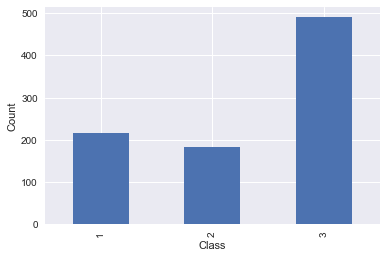

In [7]:
p = df_train.groupby("Pclass").size().plot(kind="bar")
p.set_xlabel("Class")
p.set_ylabel("Count")
p

Looks like there were more lower-class passengers than passengers of the other two classes combined.  
Also upper-class passengers could have better odds of survival. Let's check

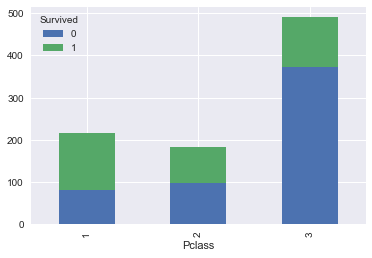

In [8]:
df_train.pivot_table("Name", "Pclass", "Survived", "count").plot(kind="bar", stacked=True)

Upper-class' odds of survival were > 50%, middle-class had roughly a 50/50 chance and lower-class' chances were only ~20%.

In [9]:
len(df_train[df_train.Pclass.isnull()])

0

##### `Name`  
###### A passenger's name  
Sometimes contains a title or other indicator of passenger's social status/age ("Rev." for "reverend", "Dr." for "doctor", "master" for "young upper-class boy", etc.), could be used in the analysis after some processing. It's likely that this information already reflected by `Pclass`, though.

In [10]:
len(df_train[df_train.Name.isnull()])

0

##### `Sex`  
###### A passenger's gender  
Due to a common maritime practice and a misunderstanding between the captain and his officers (["women and children first" vs "women and children only"](https://en.wikipedia.org/wiki/Women_and_children_first#20th_century)), women's chances of survival were dramatically higher, this feature has a great value.

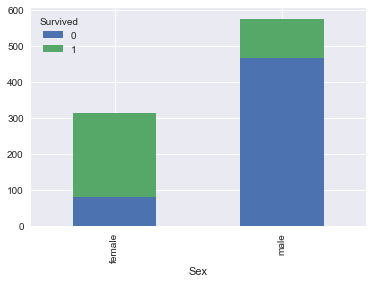

In [11]:
df_train.pivot_table("Name", "Sex", "Survived", "count").plot(kind="bar", stacked=True)

In [12]:
len(df_train[df_train.Sex.isnull()])

0

##### `Age`  
###### A passenger's age  
As well as `Sex`, it has a tremendous importance (for the same reasons).

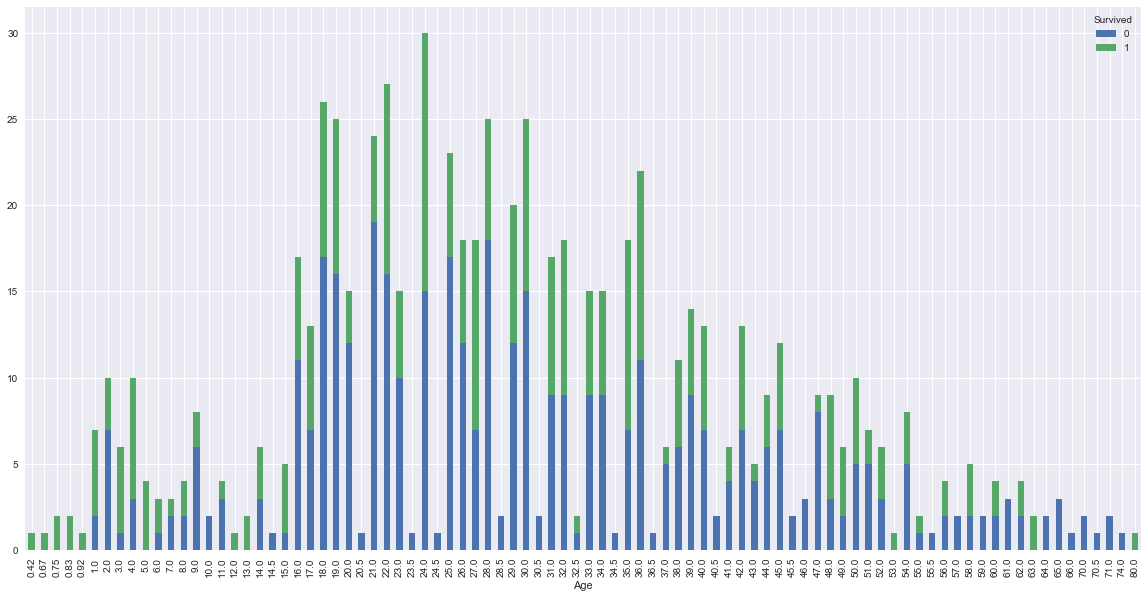

In [13]:
df_train.pivot_table("Name", "Age", "Survived", "count").plot(kind="bar", stacked=True, figsize=(20, 10))

In [14]:
len(df_train[df_train.Age.isnull()])

177

Unfortunately, some of the passengers has no `Age` filled, we'll try to recover it from other features.

##### `SibSp`  
###### A number of passenger's siblings and spouses on board  
Could be a limiting factor to the survival, since people tend to make riskier choices if significant ones are in danger. On the other hand, survived woman whose husband has died _still_ counts as a passenger with `SibSp == 1`; a controversial feature.

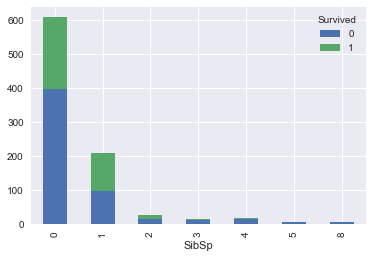

In [15]:
df_train.pivot_table("Name", "SibSp", "Survived", "count").plot(kind="bar", stacked=True)

In [16]:
len(df_train[df_train.SibSp.isnull()])

0

##### `Parch`  
###### A number of passenger's parents and children on board  
As well as `SibSp` can mean anything.

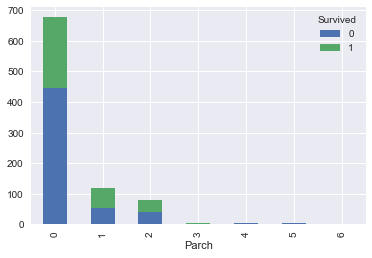

In [17]:
df_train.pivot_table("Name", "Parch", "Survived", "count").plot(kind="bar", stacked=True)

Looks pretty consistent with `SibSp`: 1 or 2 increases chances of survival, but 3+ lowers them significantly.

In [18]:
len(df_train[df_train.Parch.isnull()])

0

##### `Ticket`
###### Passenger's ticket identifier
Numbers look almost arbitrary, but many ticket numbers contain prefixes, this fact can hold some information.

In [19]:
len(df_train[df_train.Ticket.apply(lambda x: len(x.split())) > 1])

226

In [20]:
len(df_train[df_train.Ticket.isnull()])

0

##### `Fare`  
###### A ticket's price  
Most likely contains the same information as `Pclass`.

In [21]:
df_train.Fare.corr(-df_train.Pclass)

0.54949961994390784

In [22]:
len(df_train[df_train.Fare.isnull()])

0

Correlation is there, but it's moderate, so this feature can give some additional information. Also there are passengers with `Fare == 0.0`, it may (or may not) mean something.

In [23]:
len(df_train[df_train.Fare == 0.0])

15

##### `Cabin`  
###### Passenger's cabin number
Too few passengers have this information filled, but, due to the nature of this data (https://www.encyclopedia-titanica.org/cabins.html), the mere fact of having cabin number for a passenger with `Pclass != 1` may indicate their survival.

In [24]:
len(df_train[df_train.Cabin.isnull()])

687

In [25]:
sum(pd.isnull(df_train.Cabin)) / len(df_train)

0.77104377104377109

##### `Embarked`  
###### A passenger's port of departure  
It's very unlikely that this feature has anything to do with the odds of survival.

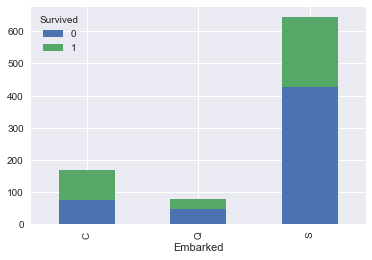

In [26]:
df_train.pivot_table("Name", "Embarked", "Survived", "count").plot(kind="bar", stacked=True)

`S` is clearly an outlier here. It can be explained by otherimportant features, such as `Sex` or `Pclass` of passengers from there. Let's take a look

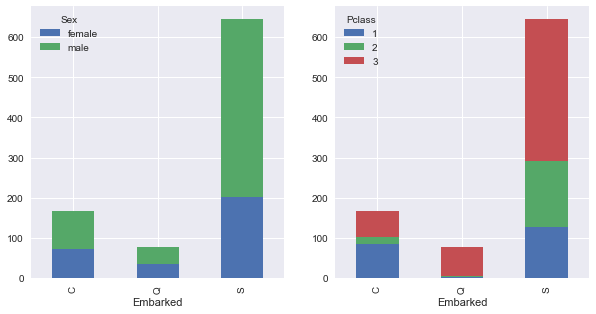

In [27]:
_, axes = plt.pyplot.subplots(ncols=2, figsize=(10, 5))
df_train.pivot_table("Name", "Embarked", "Sex", "count").plot(kind="bar", stacked=True, ax=axes[0])
df_train.pivot_table("Name", "Embarked", "Pclass", "count").plot(kind="bar", stacked=True, ax=axes[1])

Obviously, the fact that many lower-class men embarked at Southampton skews the distribution of survivors between ports.

### 2. Сгенерировать   идеи   по   преобразованию   этих   признаков

`PassengerId` — it's already perfect in its uselessness.

`Pclass` — it's categorical, makes sense to convert it to OH representation.

`Name` — extract a new feature `Title` and use it to determine `Age` for the passengers with no age and with the same title.

`Sex` — convert to OH.

`Age` — impute missing values.

`SibSp` and `Parch` — combine (sum) into a one feature.

`Ticket` — extract prefix into a separate feature, convert to OH.

`Fare` — replace 0.0 with median for a passenger's `Pclass`.

`Cabin` — convert to a new binary feature `HasCabin`.

`Embarked` — drop it.

### 3. Составить   план   по   преобразованию   признаков   -   что,   как   и   в   каком   порядке кодировать

1. Pclass to OHE
2. Encode Sex
3. Extract Title from Name; compute average Age for Title; impute missing Age by Title; scale Age
4. Sum SibSp and Parch into a new feature; scale it
5. Convert Ticket into a feature that shows that the ticket has a prefix or marked as "LINE"
6. Compute mean Fare for Pclass; impute 0.0 Fare
7. Convert Cabin to a binary feature

In [28]:
class FeatureExtractor(TransformerMixin):

    def __init__(self, new_feature_name, extractor_function):
        self.new_feature_name = new_feature_name
        self.extractor_function = extractor_function
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X[self.new_feature_name] = self.extractor_function(X)
        return X

In [29]:
class MeanByCategoryImputer(TransformerMixin):

    def __init__(self, group_key, mean_key, nan_value=None):
        self.group_key = group_key
        self.mean_key = mean_key
        self.nan_value = nan_value
    
    def fit(self, X, y=None):
        self.means_by_cat = X.groupby(self.group_key).mean()[self.mean_key].to_dict()
        return self

    def transform(self, X, y=None):
        if self.nan_value:
            X[X[self.mean_key] == self.nan_value] = np.nan
        X[self.mean_key] = X[self.mean_key].fillna(X[self.group_key].map(self.means_by_cat))
        if sum(X[self.mean_key].isnull()) > 0: # we have a 1-member group
            X[self.mean_key] = X[self.mean_key].fillna(X[self.mean_key].mean())
        return X[[self.mean_key]]

In [30]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [31]:
class FeaturesSum(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return np.sum(X.astype(np.float64), axis=1).values.reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.transform(X)

In [32]:
def prepare_pipeline():
    def get_age_col(X):
        return X.copy()[["Age", "Name"]] #  mutation ahead
    
    def get_title(X):
        return X[["Name"]].apply(lambda x: re.match(".*\, ((the )?\S*)\. .*", x.Name).groups()[0], axis=1)
    
    def get_pclass_col(X):
        return X[["Pclass"]]
    
    def get_sex_col(X):
        return X["Sex"] #  LabelEncoder expects 1d array
    
    def get_sum_col(X):
        return X[["SibSp", "Parch"]]
    
    def get_ticket_prefix(X):
        def extract_prefix(x):
            match = re.match("(.*) .*", x.Ticket.replace(".", ""))
            if match or x.Ticket == "LINE":
                return 1
            return 0
        return X[["Ticket"]].apply(extract_prefix, axis=1).values.reshape(-1, 1)
    
    def get_cabin(X):
        return X["Cabin"].isnull().astype(int) #  LabelEncoder expects 1d array
    
    pipeline = make_union(*[
        make_pipeline(FunctionTransformer(get_pclass_col, validate=False), OneHotEncoder(sparse=False)),
        make_pipeline(FunctionTransformer(get_sex_col, validate=False), LabelEncoderPipelineFriendly()),
        make_pipeline(FunctionTransformer(get_age_col, validate=False),
                      FeatureExtractor("Title", get_title), 
                      MeanByCategoryImputer("Title", "Age"),
                      StandardScaler()),
        make_pipeline(FunctionTransformer(get_sum_col, validate=False), FeaturesSum(), StandardScaler()),
        make_pipeline(FunctionTransformer(get_ticket_prefix, validate=False), OneHotEncoder(sparse=False)),
        make_pipeline(MeanByCategoryImputer("Pclass", "Fare", 0.0), StandardScaler()),
        make_pipeline(FunctionTransformer(get_cabin, validate=False), LabelEncoderPipelineFriendly())
        
    ])
    return pipeline

### 4. Составить   список   моделей   для   перебора.   Начать   с   простых   (константное преобразование,   knn).   Перейти   к   более   сложным   -   логистическая   регрессия. Описание   составить   в   виде   “модель,   какие   параметры   нужно   подбирать“.  
### Опционально.    Попробовать   наивный   байес,   SVM,   дерево   решений   и случайный   лес.

In [33]:
x = prepare_pipeline().fit_transform(df_train)
y = df_train.Survived

In [34]:
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


models = [
    (KNeighborsClassifier, {"n_neighbors": list(range(1, 21))}),
    (LogisticRegression, {"penalty": ["l1", "l2"], 
                          "C": [0.01, 0.05, 0.1, 0.5, 1.0, 5.0] + list(range(10, 101, 10)),
                          "max_iter": list(range(100, 501, 100)),
                          "random_state": [0]}),
    (SVC, {"C": [1, 10, 100, 1000], 
           "gamma": [0.1, 0.01, 0.001, 0.0001], 
           "kernel": ["rbf", "linear"],
           "random_state": [0]}),
    (DecisionTreeClassifier, {"criterion": ["gini", "entropy"], 
                              "max_depth": [None] + list(range(1, 17)),
                              "random_state": [0]}),
    (RandomForestClassifier, {"n_estimators": list(range(50, 1001, 50)),
                              "criterion": ["gini", "entropy"], 
                              "max_depth": [None] + list(range(1, 17)),
                              "random_state": [0],
                              "n_jobs": [8]})
]

### 5. Описать   процесс   кросс-валидации   и   подбора   параметров   каждой   модели   из плана   (сделать   акцент   на   кросс-валидации,   нельзя   подбирать   параметры ориентируясь   на   лидерборд)

In [35]:
best_models = []

for model, params in models:
    np.random.seed = 0
    gs = GridSearchCV(model(), params, scoring="accuracy", cv=10, n_jobs=8)
    gs.fit(x, y)
    best_models.append((gs.best_estimator_, gs.best_score_))

In [36]:
best_model = max(best_models, key=lambda x: x[1])[0]

In [37]:
test = prepare_pipeline().fit_transform(df_test)

In [43]:
prediction = best_models[2][0].predict(test)

In [44]:
result = pd.DataFrame({"PassengerId": df_test.index, "Survived": prediction})

In [45]:
result.to_csv("submission.csv", sep=",", index=False)

[(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=11, p=2,
             weights='uniform'), 0.8058361391694725),
 (LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False), 0.80471380471380471),
 (SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True,
    tol=0.001, verbose=False), 0.82491582491582494),
 (DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
           